# Cluster characterization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')
import spacy
import multiprocessing
from tqdm import tqdm
import ast
from scipy import stats

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


import re
import urllib.parse

import urlexpander

# Text preprocessiong
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

# # Topic model
# from bertopic import BERTopic
# 
# # Dimension reduction
# from umap import UMAP

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\davis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\davis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\davis\miniconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\davis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\davis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\davis\AppData\Roaming\nltk_data...
[nltk_data]   Package

In [21]:
dateparse = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S%z")  # pd.datetime.strptime

core_users_clustered = pd.read_csv("../data/core_users_clustered.csv",
                    parse_dates=['created_at'],
                    converters={"user_id": str})
tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file
                     # nrows = 400000,
                     parse_dates=['created_at'],
                     converters={"user_id": str,
                                 "tweet_id": str},
                     date_parser=dateparse,
                     lineterminator='\n')
scores = pd.read_csv("../data/scores_tweets.csv",
                    converters={"tweet_id": str})
newsguard_scores = pd.read_csv("../data/newsguard_scores.csv", #path/to/newsguard_scores_file
                              converters={"name": str},
                              lineterminator='\n')

# Converti la colonna 'score' in float, convertendo i valori non validi in NaN
newsguard_scores['score'] = pd.to_numeric(newsguard_scores['score'], errors='coerce')

# Estrai l'ora del giorno
tweets['hour_of_day'] = tweets['created_at'].dt.hour

scores = scores[(scores['tweet_id'].isin(tweets['tweet_id']))]
tweets = tweets.merge(scores, on='tweet_id', how='left')

C:\Users\davis\AppData\Local\Temp\ipykernel_10720\1023667062.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file
C:\Users\davis\AppData\Local\Temp\ipykernel_10720\1023667062.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file


In [22]:
# Elenco dei cluster che si desidera eliminare
clusters_to_remove = [3, 5, 6, 7]

# Filtra il DataFrame per mantenere solo le righe che NON appartengono ai cluster specificati
core_users_clustered = core_users_clustered[~core_users_clustered['kmeans_cluster'].isin(clusters_to_remove)]


core_users_characterization = core_users_clustered.copy()
tweets_copy = tweets.copy()

In [4]:
core_users_characterization

,user_id,created_at,user_screen_name,name,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,...,median_time_between_tweets,median_time_between_retweets,median_time_between_mentions,nbr_retweeted_accounts,nbr_domains_mean,median_words_count,median_char_count,kmeans_cluster,db_cluster,hdbscan_cluster
0,841318992094605313,2017-03-13 16:04:13+00:00,dg080310,Donato G.🇮🇹#ICEUTNE#,210.0,486.0,49.0,0.0,3.0,False,...,161.750000,4654.916667,15983.0,15.0,0.482213,22.0,165.0,4,-1,0
1,1218242063638188033,2020-01-17 18:42:36+00:00,Fidelio16852684,Fidelio,0.0,0.0,97.0,0.0,8.0,False,...,355.958333,2029.966667,69002.0,2.0,1.952663,39.0,261.0,2,-1,0
2,1311952044144685056,2020-10-02 08:52:58+00:00,IlS0vran,ilS0vranIsta,36.0,35.0,1.0,1.0,17.0,False,...,1496.600000,2215.358333,75062.0,7.0,0.550725,24.5,153.0,1,-1,0
3,52021947,2009-06-29 10:46:16+00:00,marcobobabo,Marco D'Addabbo,10.0,167.0,368.0,0.0,24.0,False,...,809.083333,NaN,48545.0,NaN,0.117647,43.0,280.5,2,-1,0
4,1298360422433730560,2020-08-25 20:43:52+00:00,Sararisso3,APOCALYPTO. IL SONNO DELLA RAGIONE GENERA MOSTRI.,46.0,25.0,0.0,0.0,52.0,False,...,637.300000,252.758333,9345.0,121.0,0.595960,20.0,140.0,4,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6955,2661597937,2014-07-20 03:46:07+00:00,Sergei_Ardzinba,Sergei Ardzinba,12662.0,236.0,7986.0,38.0,515785.0,False,...,1161.250000,NaN,NaN,NaN,2.000000,9.0,74.0,0,-1,0
6976,2321365020,2014-01-31 21:19:18+00:00,stiripesurse_ro,stiripesurse.ro,7810.0,28.0,59.0,68.0,584386.0,False,...,110.016667,NaN,NaN,NaN,2.000000,1.0,23.0,0,-1,0
6984,317742806,2011-06-15 12:09:42+00:00,infoitsalute,informazione salute,950.0,0.0,0.0,64.0,675656.0,False,...,0.000000,NaN,NaN,NaN,2.014342,13.0,102.0,0,-1,0
6989,276544322,2011-04-03 15:41:20+00:00,EugenioBerto70,Eugenio,889.0,1896.0,277.0,241.0,776750.0,False,...,0.100000,NaN,NaN,NaN,2.000000,9.0,81.0,0,-1,0


## 1. Caratterizzazione in base agli utenti

### 1.1. Media dei valori delle caratteristiche per ogni cluster

In [5]:
mean_values = core_users_characterization.groupby('kmeans_cluster').mean(numeric_only=True)
mean_values['n_users'] = core_users_characterization.groupby('kmeans_cluster')['user_id'].count()
mean_values


,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,protected,nbr_accounts,nbr_usernames,favorites_ratio,...,median_time_between_tweets,median_time_between_retweets,median_time_between_mentions,nbr_retweeted_accounts,nbr_domains_mean,median_words_count,median_char_count,db_cluster,hdbscan_cluster,n_users
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,15807.630588,853.621176,5839.382353,117.760000,68679.740000,0.062353,0.0,1.000000,1.014118,0.154366,...,1127.592360,7486.733123,348870.706434,15.669118,1.857262,14.852163,120.840144,-0.969412,-0.004706,850
1,1297.061206,1041.513051,50074.131413,11.010801,42310.747975,0.001800,0.0,1.003150,1.045455,1.832437,...,3777.007314,1068.680580,34674.210538,88.032877,0.232775,16.938182,116.612273,-1.000000,-0.002700,2222
2,9234.142712,1266.637105,29160.994903,61.978593,34005.224261,0.053007,0.0,1.001019,1.053007,1.268661,...,1028.644544,5447.040482,79182.898069,29.516827,0.417556,33.083588,226.692151,-1.000000,-0.002039,981
4,3070.077643,1590.486149,56608.953180,31.900507,54473.548966,0.008974,0.0,1.000390,1.046430,1.529416,...,2156.573044,1469.264639,41526.250684,80.145168,0.241973,17.833268,122.403492,-1.000000,-0.000390,2563


#### Descrizione clusters

- cluster 0: uno dei due cluster con la quanità più alta di utenti, con un numero medio di followers, following e liked_tweets, e un following ratio medio. Inoltre possiede un numero di lists e tweets relativamente basso a confronto degli alri cluster. Si può anche considerare che è un cluster misto tra utenti verificati e non verificati, con una maggioranza di utenti non verificati.
- cluster 1: appartiene al gruppo dei cluster con meno utenti, infatti è composto da soli 2 utenti. Questi utenti hanno un numero di followers, following, liked_tweets, following ratio e numero di tweets molto basso. Inoltre possiedono un numero di lists nullo. Si può anche considerare che è un cluster di soli utenti non verificati.
- cluster 2: fa anch'esso parte del gruppo con pochi utenti, ma è quello più numeroso tra questi clusters con 14 utenti. Questi utenti hanno un numero di followers, tweets e lists molto alto, mentre following, liked_tweets e following ratio relativamente bassi. Si può anche considerare che è un cluster di utenti quasi tutti verificati.
- cluster 3: è l'altro cluster dei 2 che contiene il maggior numero di utenti. Questi utenti hanno un numero di followers, following, lists e following ratio nella media. Mentre un numero di liked_tweets e numero di tweets molto alto. Si può anche considerare che è un cluster misto di utenti verificati e non, con prevalenza di utenti non verificati.
- cluster 4:

### 1.2. Mediana dei valori delle caratteristiche per ogni cluster

In [8]:
median_values = core_users_characterization.groupby('kmeans_cluster').median(numeric_only=True)
median_values['n_users'] = core_users_characterization.groupby('kmeans_cluster')['user_id'].count()
median_values


,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,protected,nbr_accounts,nbr_usernames,favorites_ratio,...,median_time_between_tweets,median_time_between_retweets,median_time_between_mentions,nbr_retweeted_accounts,nbr_domains_mean,median_words_count,median_char_count,db_cluster,hdbscan_cluster,n_users
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,1186.5,245.0,72.5,19.5,39258.0,0.0,0.0,1.0,1.0,0.002014,...,881.133333,2139.062500,85873.00,7.0,2.000000,15.0,118.00,-1.0,0.0,850
1,418.0,591.5,31654.5,1.0,25223.0,0.0,0.0,1.0,1.0,1.214689,...,1295.170833,439.941667,16703.00,66.0,0.174977,18.0,125.25,-1.0,0.0,2222
2,751.0,641.0,12178.0,5.0,19696.0,0.0,0.0,1.0,1.0,0.752993,...,507.129167,1729.750000,33232.75,19.0,0.211982,33.0,225.00,-1.0,0.0,981
4,952.0,997.0,36673.0,5.0,37407.0,0.0,0.0,1.0,1.0,1.092271,...,994.108333,576.600000,18280.50,60.0,0.190083,19.0,135.00,-1.0,0.0,2563


### 1.3. Varianza dei valori delle caratteristiche per ogni cluster

In [9]:
var_values = core_users_characterization.groupby('kmeans_cluster').var(numeric_only=True)
var_values['n_users'] = core_users_characterization.groupby('kmeans_cluster')['user_id'].count()
var_values


,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,protected,nbr_accounts,nbr_usernames,favorites_ratio,...,median_time_between_tweets,median_time_between_retweets,median_time_between_mentions,nbr_retweeted_accounts,nbr_domains_mean,median_words_count,median_char_count,db_cluster,hdbscan_cluster,n_users
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,4.953347e+09,2.435640e+06,3.688608e+08,111623.332203,7.445407e+09,0.058534,0.0,0.000000,0.018646,0.308995,...,1.114271e+07,2.112906e+08,7.394390e+11,595.897493,0.124502,24.473305,1280.139879,0.050889,0.004689,850
1,2.841515e+08,1.629856e+06,3.047501e+09,1534.840946,2.188226e+09,0.001798,0.0,0.004042,0.121751,5.747019,...,9.718569e+07,1.133665e+07,3.978805e+09,5709.490924,0.044659,22.477759,928.420086,0.000000,0.002694,2222
2,2.117750e+09,3.648953e+06,2.524432e+09,39396.316888,2.678744e+09,0.050249,0.0,0.001019,0.070657,3.510428,...,7.578157e+06,1.343407e+08,4.546372e+10,1149.780703,0.287194,27.818006,1446.990846,0.000000,0.002037,981
4,2.539356e+08,3.147345e+06,3.420898e+09,13813.098997,2.887983e+09,0.008897,0.0,0.000390,0.069272,3.183337,...,2.059659e+07,1.911502e+07,8.492963e+09,4896.296203,0.041906,20.358963,806.225965,0.000000,0.000390,2563


### 1.4. Deviazione standard dei valori delle caratteristiche per ogni cluster

In [10]:
std_values = core_users_characterization.groupby('kmeans_cluster').std(numeric_only=True)
std_values['n_users'] = core_users_characterization.groupby('kmeans_cluster')['user_id'].count()
std_values


,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,protected,nbr_accounts,nbr_usernames,favorites_ratio,...,median_time_between_tweets,median_time_between_retweets,median_time_between_mentions,nbr_retweeted_accounts,nbr_domains_mean,median_words_count,median_char_count,db_cluster,hdbscan_cluster,n_users
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,70380.020052,1560.653721,19205.748099,334.100782,86286.771846,0.241938,0.0,0.000000,0.136551,0.555873,...,3338.069140,14535.839763,859906.364157,24.411012,0.352848,4.947050,35.779042,0.225586,0.068478,850
1,16856.793111,1276.658039,55204.171404,39.177046,46778.481887,0.042400,0.0,0.063579,0.348928,2.397294,...,9858.280366,3366.994410,63077.769816,75.561173,0.211326,4.741072,30.469987,0.000000,0.051906,2222
2,46019.020487,1910.223312,50243.723115,198.485055,51756.583510,0.224162,0.0,0.031928,0.265813,1.873614,...,2752.845276,11590.543510,213222.224545,33.908416,0.535905,5.274278,38.039333,0.000000,0.045129,981
4,15935.355521,1774.075830,58488.443495,117.529141,53739.953450,0.094323,0.0,0.019753,0.263196,1.784191,...,4538.346741,4372.073126,92157.271644,69.973539,0.204709,4.512091,28.394118,0.000000,0.019753,2563


### 1.5. Distribuzione delle caratteristiche per ogni cluster

#### 1.5.1. Distribuzione del following_ratio per ogni cluster

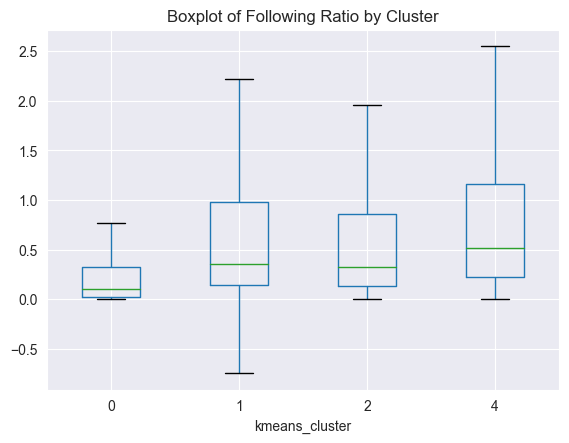

In [11]:
# # Facciamo un loop attraverso ogni cluster e creiamo un box plot per ciascuno
# for cluster in core_users_characterization['kmeans_cluster'].unique():
#     sns.boxplot(x=core_users_characterization[core_users_characterization['kmeans_cluster']==cluster]['following_ratio'])
#     plt.title(f'Box plot of following_ratio for cluster {cluster}')
#     plt.show()

core_users_characterization.boxplot(column='following_ratio', by='kmeans_cluster', showfliers=False)
plt.title('Boxplot of Following Ratio by Cluster')
plt.suptitle('')  # rimuove il titolo automatico generato da pandas
plt.show()


#### 1.5.2. Distribuzione dei followers per ogni cluster

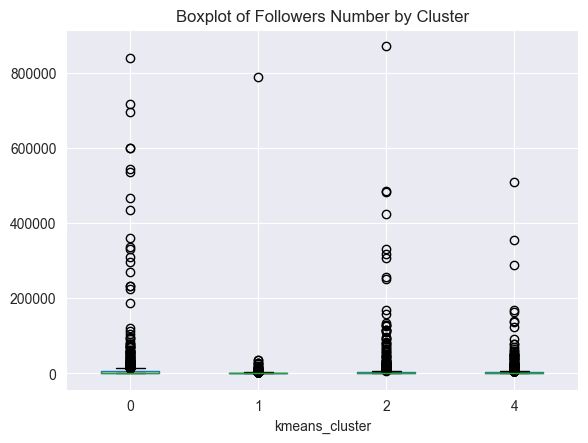

In [12]:
core_users_characterization.boxplot(column='nbr_followers', by='kmeans_cluster')
plt.title('Boxplot of Followers Number by Cluster')
plt.suptitle('')  # rimuove il titolo automatico generato da pandas
plt.show()


## 2. Caratterizzazione in base ai tweet

In [17]:
# Unisci i DataFrame sulla base dell'user_id
tweets_copy = pd.merge(tweets_copy, core_users_characterization[['user_id', 'kmeans_cluster']], on='user_id', how='left')

### 2.1. Media dei valori delle caratteristiche per ogni cluster

In [17]:
cluster_scores = tweets_copy.groupby('kmeans_cluster')[['toxicity', 'positive_y', 'negative_y']].describe()
cluster_scores

toxicity                                                    \
                   count      mean       std       min       25%       50%   
kmeans_cluster                                                               
0.0             134952.0  0.038028  0.071053  0.000596  0.004300  0.012769   
1.0             148331.0  0.119767  0.144371  0.000514  0.018637  0.065327   
2.0             121347.0  0.126708  0.142866  0.000534  0.023742  0.074613   
4.0             205752.0  0.119482  0.143446  0.000514  0.018957  0.065589   

                                   positive_y            ...            \
                     75%       max      count      mean  ...       75%   
kmeans_cluster                                           ...             
0.0             0.038742  0.986261   134536.0  0.062824  ...  0.073255   
1.0             0.169418  0.997949   141246.0  0.168405  ...  0.219643   
2.0             0.181565  0.996717   120244.0  0.100293  ...  0.129565   
4.0             0.168650  0.998258   197665.0  0.160645  ...  0.211542   

                         negative_y                                          \
                     max      count      mean       std       min       25%   
kmeans_cluster                                                                
0.0             0.995159   134536.0  0.090409  0.161051  0.000003  0.000777   
1.0             0.997090   141246.0  0.266782  0.262599  0.000005  0.028241   
2.0             0.997270   120244.0  0.227400  0.267316  0.000004  0.003291   
4.0             0.998315   197665.0  0.263822  0.263472  0.000005  0.024845   

                                              
                     50%       75%       max  
kmeans_cluster                                
0.0             0.011776  0.102053  0.994099  
1.0             0.181054  0.458452  0.993499  
2.0             0.095550  0.415104  0.991751  
4.0             0.175155  0.457944  0.991776  

[4 rows x 24 columns]

### 2.2. Confronto delle distribuzioni

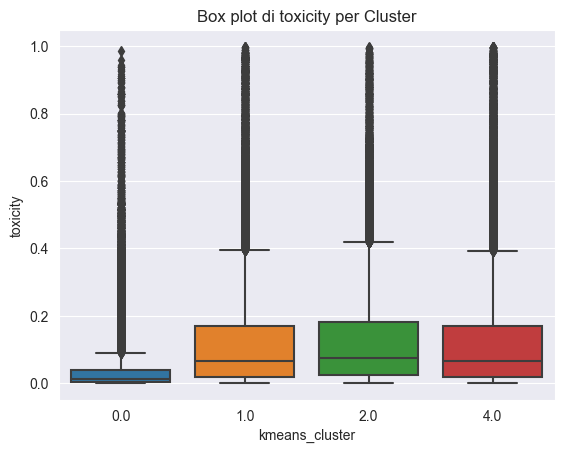

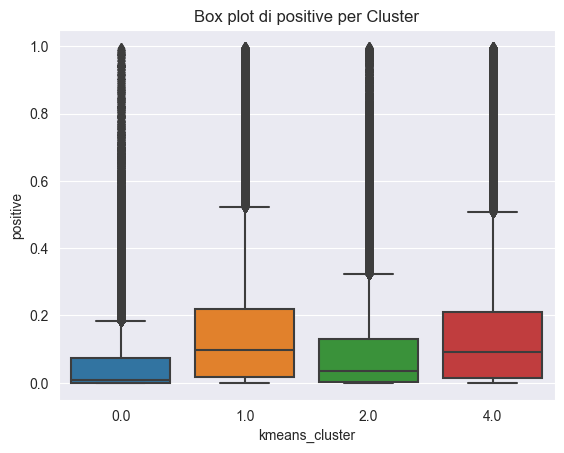

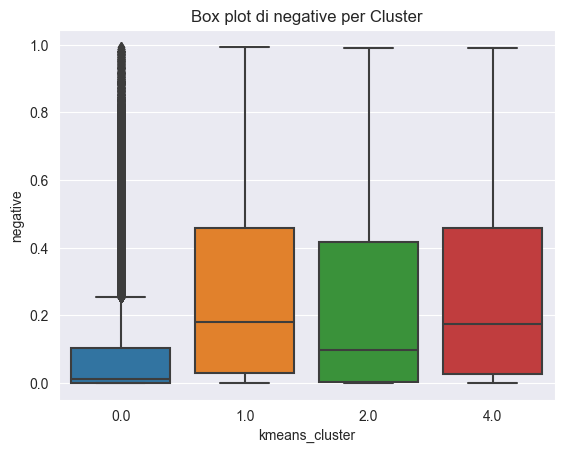

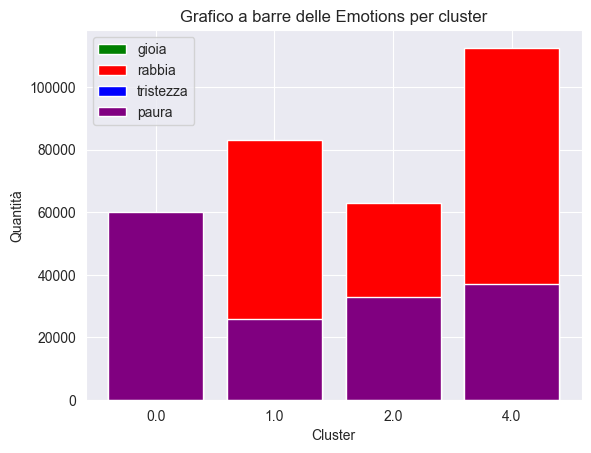

In [19]:
score_names = {
    'toxicity': 'toxicity',
    'positive_y': 'positive',
    'negative_y': 'negative'
}

for score in ['toxicity', 'positive_y', 'negative_y']:
    # plt.figure(figsize=(10, 6))
    sns.boxplot(x='kmeans_cluster', y=score, data=tweets_copy)
    plt.title(f'Box plot di {score_names[score]} per Cluster')
    plt.ylabel(score_names[score])
    plt.show()





emotion_names = {
    'joy': 'gioia',
    'anger': 'rabbia',
    'sadness': 'tristezza',
    'fear': 'paura'
}

# Conta il numero di occorrenze di ogni emozione per ogni cluster
emotion_counts = tweets_copy.groupby(['kmeans_cluster', 'emotion']).size().unstack()

# Plot a bar chart for each emotion
emotions = ['joy', 'anger', 'sadness', 'fear']
colors = ['green', 'red', 'blue', 'purple']

# plt.figure(figsize=(10, 6))
for i, emotion in enumerate(emotions):
    plt.bar(range(len(emotion_counts)), emotion_counts[emotion], label=emotion_names[emotion], color=colors[i])

# Imposta le etichette per l'asse x usando i cluster originali
plt.xticks(range(len(emotion_counts)), emotion_counts.index.values)

plt.xlabel('Cluster')
plt.ylabel('Quantità')
plt.title('Grafico a barre delle Emotions per cluster')
plt.legend()
plt.show()


### 2.3. Test statistici

In [11]:
for score in ['toxicity', 'positive_y', 'negative_y']:
    print(f"Test statistico per {score}:\n{stats.ttest_ind(tweets_copy[tweets_copy['kmeans_cluster'] == 0][score],                          tweets_copy[tweets_copy['kmeans_cluster'] == 1][score], nan_policy='omit')}")


Test statistico per toxicity:
TtestResult(statistic=-188.27400673676001, pvalue=0.0, df=283281.0)
Test statistico per positive_y:
TtestResult(statistic=-161.2699538031646, pvalue=0.0, df=275780.0)
Test statistico per negative_y:
TtestResult(statistic=-211.38078362404733, pvalue=0.0, df=275780.0)


#### 2.3.1. Test ANOVA

In [7]:
# Crea una copia del dataframe
tweets_copy_filtered = tweets_copy.copy()

# Rimuove le righe con NaN nelle colonne 'toxicity', 'positive_y', e 'negative_y'
tweets_copy_filtered = tweets_copy_filtered.dropna(subset=['toxicity', 'positive_y', 'negative_y'])

# Lista dei clusters da analizzare
clusters_to_analyze = [0, 1, 2, 4]

# Esegui il test ANOVA per ogni variabile
for score in ['toxicity', 'positive_y', 'negative_y']:
    
    # Crea una lista che contiene i dati di ogni cluster per la variabile corrente
    data = [tweets_copy_filtered[tweets_copy_filtered['kmeans_cluster'] == cluster][score] for cluster in clusters_to_analyze]
    
    # Esegui il test ANOVA
    f_statistic, p_value = stats.f_oneway(*data)
    
    # Stampa i risultati
    print(f"Test ANOVA per {score}:")
    print(f"F Statistic: {f_statistic:.5f}")
    print(f"P Value: {p_value:.5f}\n")

Test ANOVA per toxicity:
F Statistic: 15315.23452
P Value: 0.00000
Test ANOVA per positive_y:
F Statistic: 11300.16449
P Value: 0.00000
Test ANOVA per negative_y:
F Statistic: 16435.61441
P Value: 0.00000


#### 2.3.2. Test di Tukey (HSD - Honestly Significant Difference)

In [11]:
# Creiamo una copia del dataframe
tweets_copy_clean = tweets_copy.dropna(subset=['toxicity', 'positive_y', 'negative_y'])

# Lista dei clusters da analizzare
clusters_to_analyze = [0, 1, 2, 4]

# Filtra il dataframe in base ai clusters selezionati
filtered_data = tweets_copy_clean[tweets_copy_clean['kmeans_cluster'].isin(clusters_to_analyze)]

# Esegui l'analisi post-hoc con il test di Tukey per ogni variabile
for score in ['toxicity', 'positive_y', 'negative_y']:
    
    print(f"\nTest di Tukey (HSD) per {score}:\n")
    
    # Esegui il test di Tukey
    tukey_result = pairwise_tukeyhsd(endog=filtered_data[score],     # Data
                                     groups=filtered_data['kmeans_cluster'],  # Gruppi
                                     alpha=0.05)                       # Livello di significatività
    
    # Stampa i risultati
    print(tukey_result)



Test di Tukey (HSD) per toxicity:

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0871    0.0  0.0858  0.0884   True
   0.0    2.0   0.0897    0.0  0.0883   0.091   True
   0.0    4.0   0.0858    0.0  0.0846   0.087   True
   1.0    2.0   0.0026    0.0  0.0012  0.0039   True
   1.0    4.0  -0.0013 0.0234 -0.0025 -0.0001   True
   2.0    4.0  -0.0039    0.0 -0.0051 -0.0026   True
----------------------------------------------------

Test di Tukey (HSD) per positive_y:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0   0.1056   0.0  0.1038  0.1073   True
   0.0    2.0   0.0375   0.0  0.0356  0.0393   True
   0.0    4.0   0.0978   0.0  0.0962  0.0995   True
   1.0    2.0  -0.0681   0.0 -0.0699 -0.0663   True
   1.0    4.0  -0.0078   0.0 -0.0

### 2.4. Analisi temporale

<Figure size 640x480 with 0 Axes>

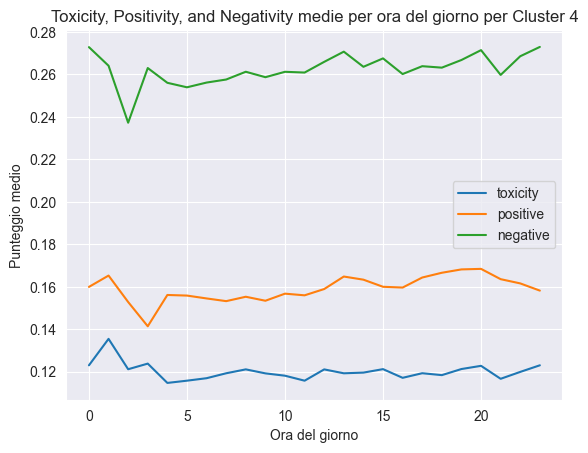

<Figure size 640x480 with 0 Axes>

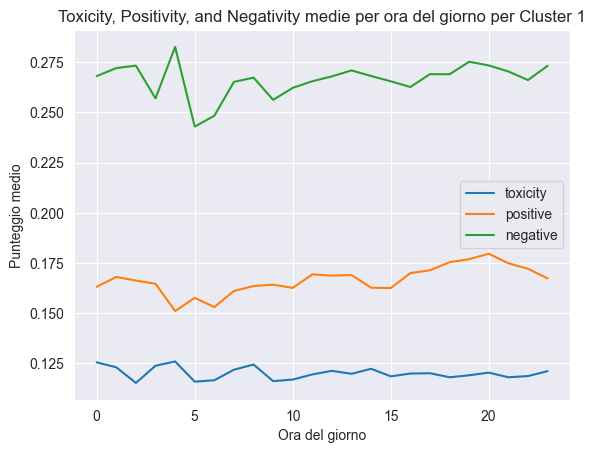

<Figure size 640x480 with 0 Axes>

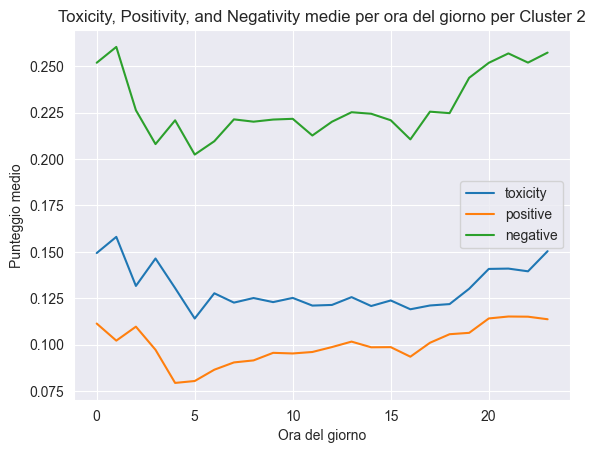

<Figure size 640x480 with 0 Axes>

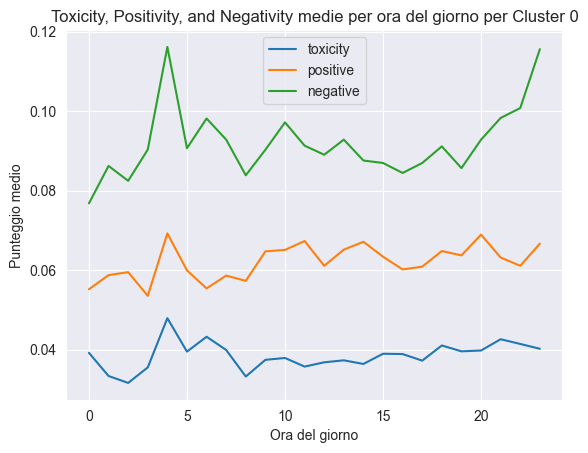

In [20]:
# # Calcola e visualizza la matrice di correlazione per ogni cluster
# clusters = tweets_copy['kmeans_cluster'].unique()

score_names = {
    'toxicity': 'toxicity',
    'positive_y': 'positive',
    'negative_y': 'negative'
}

# Seleziona i cluster d'interesse
clusters = [4, 1, 2, 0]

# Calcola e visualizza le medie di tossicità, positività e negatività per ogni ora del giorno, per ogni cluster
for cluster in clusters:
    cluster_data = tweets_copy[tweets_copy['kmeans_cluster'] == cluster]
    average_scores_by_hour = cluster_data.groupby('hour_of_day')[['toxicity', 'positive_y', 'negative_y']].mean()
    plt.figure()
    average_scores_by_hour.plot(kind='line')
    plt.title(f'Toxicity, Positivity, and Negativity medie per ora del giorno per Cluster {cluster}')
    plt.xlabel('Ora del giorno')
    plt.ylabel('Punteggio medio')
    
    # Sostituisci i label della legenda con quelli nel dizionario score_names
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [score_names[label] for label in labels]
    plt.legend(handles, new_labels)
    
    plt.show()


## 3. Distribuzione dei valori delle caratteristiche per ogni cluster

Il formato del DataFrame cluster_tweets, in ogni riga rappresenta un cluster e la colonna combined_text contiene una lista di tuple. Ogni tupla rappresenta una parola (o token) e il suo conteggio nel cluster.

In questo codice, utilizziamo la funzione nlp di spaCy per eseguire una serie di operazioni di elaborazione del linguaggio naturale sul testo, tra cui la tokenizzazione, la lemmatizzazione e la rimozione delle stop words. La funzione nlp restituisce un oggetto Doc che può essere iterato per ottenere ciascuna parola (o "token") nel testo. Per ciascun token, usiamo l'attributo lemma_ per ottenere la forma base della parola, e l'attributo is_alpha per escludere i segni di punteggiatura.

### 3.1. Preprocessing dei dati

Preparazione dei dati per l'analisi del testo, creando un dataframe apposito.

In [23]:
# Unisci i due DataFrame sulla base del user_id
merged_df = pd.merge(tweets, core_users_characterization, on='user_id')

# Sostituisci i valori NaN con '' nelle colonne 'text', 'retweeted_text' e 'quoted_text'
merged_df['text'] = merged_df['text'].fillna('')
merged_df['retweeted_text'] = merged_df['retweeted_text'].fillna('')
merged_df['quoted_text'] = merged_df['quoted_text'].fillna('')

# # Sostituisci 'https' con una stringa vuota nelle colonne 'text', 'retweeted_text' e 'quoted_text'
# merged_df['text'] = merged_df['text'].str.replace('https', '')
# merged_df['retweeted_text'] = merged_df['retweeted_text'].str.replace('https', '')
# merged_df['quoted_text'] = merged_df['quoted_text'].str.replace('https', '')

# Assicurati che tutti i valori nelle colonne 'text', 'retweeted_text' e 'quoted_text' siano stringhe
merged_df['text'] = merged_df['text'].astype(str)
merged_df['retweeted_text'] = merged_df['retweeted_text'].astype(str)
merged_df['quoted_text'] = merged_df['quoted_text'].astype(str)

# Crea una nuova colonna 'combined_text' che combina i contenuti dei campi 'text', 'retweeted_text' e 'quoted_text'
merged_df['combined_text'] = merged_df.apply(lambda row: ' '.join([row['text'], row['retweeted_text'], row['quoted_text']]), axis=1)

# Rimuovi i spazi vuoti iniziali e finali e sostituisci più spazi con uno solo
merged_df['combined_text'] = merged_df['combined_text'].str.strip().replace(' +', ' ', regex=True)

merged_df


,tweet_id,created_at_x,user_id,user_screen_name_x,geo,place,lang,truncated,text,retweet_count,...,median_time_between_retweets,median_time_between_mentions,nbr_retweeted_accounts,nbr_domains_mean,median_words_count,median_char_count,kmeans_cluster,db_cluster,hdbscan_cluster,combined_text
0,1340465924932063236,2020-12-20 01:15:55+00:00,457762156,BosioFabrizio,NaN,NaN,it,NaN,,279,...,564.166667,25329.5,76.0,0.413408,13.0,100.0,4,-1,0,Politici avvertiti: chi impone vaccini obbliga...
1,1340735780608684033,2020-12-20 19:08:14+00:00,457762156,BosioFabrizio,NaN,NaN,it,NaN,,21,...,564.166667,25329.5,76.0,0.413408,13.0,100.0,4,-1,0,Secondo il CDC nei primi 5 giorni di somminist...
2,1340738201879801859,2020-12-20 19:17:51+00:00,457762156,BosioFabrizio,NaN,NaN,it,NaN,,22,...,564.166667,25329.5,76.0,0.413408,13.0,100.0,4,-1,0,"@braveheartmmt Altre reazioni avverse , addiri..."
3,1340738566335426560,2020-12-20 19:19:18+00:00,457762156,BosioFabrizio,NaN,NaN,it,NaN,,3,...,564.166667,25329.5,76.0,0.413408,13.0,100.0,4,-1,0,@braveheartmmt Non è possibile continuare le v...
4,1340830766767501312,2020-12-21 01:25:40+00:00,457762156,BosioFabrizio,NaN,NaN,it,NaN,,177,...,564.166667,25329.5,76.0,0.413408,13.0,100.0,4,-1,0,Ma pensa te dopo tutta sta fatica per trovare ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550203,1375714418575687680,2021-03-27 07:40:51+00:00,1355805072530305027,Gertrud84929332,NaN,NaN,it,1.0,"Il vaccino (peraltro sperimentale, ossia testa...",0,...,514.633333,6093.0,37.0,0.653061,14.0,112.0,1,-1,0,"Il vaccino (peraltro sperimentale, ossia testa..."
1550204,1375740285410496513,2021-03-27 09:23:38+00:00,1355805072530305027,Gertrud84929332,NaN,NaN,it,0.0,RT @ilReazionario: Scacco matto. 😳 https://t.c...,0,...,514.633333,6093.0,37.0,0.653061,14.0,112.0,1,-1,0,RT @ilReazionario: Scacco matto. 😳 https://t.c...
1550205,1375742385267834881,2021-03-27 09:31:59+00:00,1355805072530305027,Gertrud84929332,NaN,NaN,it,0.0,,0,...,514.633333,6093.0,37.0,0.653061,14.0,112.0,1,-1,0,"La mascherina all’aperto non serve, ma la devi..."
1550206,1375744499775864832,2021-03-27 09:40:23+00:00,1355805072530305027,Gertrud84929332,NaN,NaN,it,0.0,RT @DHofmannsthal: Narrazione per idioti. Litu...,0,...,514.633333,6093.0,37.0,0.653061,14.0,112.0,1,-1,0,RT @DHofmannsthal: Narrazione per idioti. Litu...


### 3.2. Misinformation score

In [22]:
link_extraction = merged_df[['user_id', 'kmeans_cluster', 'combined_text']]

#### 3.2.1. Link extraction

In [23]:
# Estrai tutti i link dai tweet
link_extraction['link'] = link_extraction['combined_text'].apply(lambda x: re.findall(r'(https?://[^\s]+)', x))

link_extraction


C:\Users\davis\AppData\Local\Temp\ipykernel_12924\3292567133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  link_extraction['link'] = link_extraction['combined_text'].apply(lambda x: re.findall(r'(https?://[^\s]+)', x))


,user_id,kmeans_cluster,combined_text,link
0,457762156,4,Politici avvertiti: chi impone vaccini obbliga...,[https://t.co/Qwq0OX6xjk]
1,457762156,4,Secondo il CDC nei primi 5 giorni di somminist...,[]
2,457762156,4,"@braveheartmmt Altre reazioni avverse , addiri...",[https://t.co/sO0AONgzEu]
3,457762156,4,@braveheartmmt Non è possibile continuare le v...,[]
4,457762156,4,Ma pensa te dopo tutta sta fatica per trovare ...,[https://t.co/DUiENRrpOc]
...,...,...,...,...
1550203,1355805072530305027,1,"Il vaccino (peraltro sperimentale, ossia testa...",[https://t.co/Ovxzv90Vzm]
1550204,1355805072530305027,1,RT @ilReazionario: Scacco matto. 😳 https://t.c...,"[https://t.co/4pfyiqcW9e, https://t.co/yhhfbDk..."
1550205,1355805072530305027,1,"La mascherina all’aperto non serve, ma la devi...",[]
1550206,1355805072530305027,1,RT @DHofmannsthal: Narrazione per idioti. Litu...,[https://t.co/mdHtbav5Az]


#### 3.2.2. Link parser

In [46]:
# link_extraction = link_extraction.apply(lambda x: x[:100])

def expand_urls_in_dataframe(df):
    print("Inizio l'espansione degli URL")
    for i in tqdm(range(len(df))):
        links = df.loc[i, 'link']
        expanded_links = []
        for link in links:
            try:
                expanded_link = urlexpander.expand(link)
            except:
                expanded_link = np.NaN
            expanded_links.append(expanded_link)
        df.loc[i, 'link'] = str(expanded_links)  # converti la lista in una stringa
    return df

# Espande gli URL
expand_urls_in_dataframe(link_extraction)

link_extraction


Inizio l'espansione degli URL


100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


,user_id,kmeans_cluster,combined_text,link
0,398032197,3,“Per ora” non prevedono di vaccinare i bambini...,['http://twitter.com\\__CLIENT_ERROR__']
1,398032197,3,"Conte, nominato da un partito di anti-vaccinis...",[]
2,398032197,3,Ranieri Guerra “La #variantecovid “inglese”è p...,[]
3,398032197,3,Quindi in meno di 24 ore hanno isolato una “va...,[]
4,398032197,3,TOH!! \nLa #variantecovid (che è più contagios...,['http://twitter.com\\__CLIENT_ERROR__']
...,...,...,...,...
95,398032197,3,"RT @rekotc: Fossero davvero i bei tempi, i due...",['http://twitter.com\\__CLIENT_ERROR__']
96,398032197,3,RT @EmpfindsamerS: Potrei anche accettare l'id...,['http://twitter.com\\__CLIENT_ERROR__']
97,398032197,3,"Vaccino Pfizer, effetti collaterali negli Usa:...",['https://www.iltempo.it/esteri/2020/12/17/new...
98,398032197,3,"Da oggi e per i prossimi giorni in tv, h24, i ...",['http://twitter.com\\__CLIENT_ERROR__']


In [ ]:
# Data saving
link_extraction.to_csv('../data/parsed_link.csv', index=False)

#### 3.2.3. Estrazione dominio e associazione con Newsguard

In [ ]:
# Link parser file già disponibile
parsed_link = link_extraction.copy()
core_url_parsati = pd.read_csv('../data/core_url_parsati.csv')

# Crea una serie dove gli indici sono gli URL originali e i valori sono gli URL parsati
url_mapping = pd.Series(core_url_parsati.parsed.values, index=core_url_parsati.original).to_dict()

# Sostituisci i valori nella colonna 'link' usando il dizionario appena creato
parsed_link['link'] = parsed_link['link'].apply(lambda x: [url_mapping[url] if url in url_mapping else url for url in x])




# Link parser file appena elaborato
# Carica il file con gli URL espansi
# parsed_link = pd.read_csv('../data/parsed_link.csv')



# Funzione per estrarre domini dai link
def extract_domain(link_list):
    if link_list:  # Se la lista non è vuota
        link = link_list[0]
        parsed_uri = urllib.parse.urlparse(link)
        domain = '{uri.netloc}'.format(uri=parsed_uri)
        return domain
    else:  # Se la lista è vuota
        return None

# Estrai il dominio da ogni link
parsed_link['domain'] = parsed_link['link'].apply(extract_domain)

# Unisci i tweet con newsguard_score in base al dominio
parsed_link = parsed_link.merge(newsguard_scores, left_on='domain', right_on='name', how='left')

parsed_link


#### 3.2.4. Data rappresentation

In [ ]:
cluster_scores = parsed_link.dropna(subset=['score'])


# Calcola la media dello score per ciascun cluster
avg_scores = cluster_scores.groupby('kmeans_cluster')['score'].mean()

# Crea il grafico a barre
avg_scores.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Media dello score')
plt.title('Analisi dei punteggi per i vari cluster')
plt.show()


cluster_scores


### 3.3. Lemmatizzazione dei testi

In [24]:
merged_df['combined_text'] = merged_df['combined_text'].str.replace('https', '')

# Crea un nuovo DataFrame dove ogni riga rappresenta un cluster e la colonna è una lista di tutti i tweet di quel cluster
cluster_tweets = merged_df.groupby('kmeans_cluster')['combined_text'].apply(list).reset_index()

cluster_tweets

,kmeans_cluster,combined_text
0,0,"[(Il Capo della Pfize, Albert Bourla ha dichia..."
1,1,[#Tremonti: in tutta Europa usano le palestre ...
2,2,[@maxdantoni E questo è quello che dice il Bri...
3,4,[Politici avvertiti: chi impone vaccini obblig...


In [25]:
# Carica il modello italiano di spaCy disabilitando il NER
nlp = spacy.load('it_core_news_sm', disable=['ner', 'parser'])

stopwords = nltk.corpus.stopwords.words('italian')

def process_texts(text_list):
    processed_texts = []
    for text in tqdm(text_list, desc='Processing texts'):
        text = text.lower()
        doc = nlp(text)
        text_lemmatized = ' '.join([token.lemma_ for token in doc if token.text not in stopwords and not token.is_punct])
        processed_texts.append(text_lemmatized)
    return processed_texts

cluster_tweets['processed_texts'] = cluster_tweets['combined_text'].apply(lambda x: list(tqdm(process_texts(x), desc='Applying function')))

cluster_tweets

Applying function: 100%|██████████| 621724/621724 [00:00<00:00, 4325210.12it/s]


,kmeans_cluster,combined_text,processed_texts
0,0,"[(Il Capo della Pfize, Albert Bourla ha dichia...",[capo pfize albert bourla dichiarare vaccino s...
1,1,[#Tremonti: in tutta Europa usano le palestre ...,[tremonte tutto Europa usare palestre edificio...
2,2,[@maxdantoni E questo è quello che dice il Bri...,[@maxdantone dire british Medical journal rece...
3,4,[Politici avvertiti: chi impone vaccini obblig...,[politico avvertire imporre vaccino obbligator...


#### 3.3.1. Data saving

In [23]:
lemmatized_text = cluster_tweets[['kmeans_cluster', 'processed_texts']].copy()
# Salva il DataFrame in un file pickle
lemmatized_text.to_pickle("../data/lemmatized_text.pkl")

### 3.4. Creazione del modello BERTopic

In [32]:
# Carica il DataFrame da file
lemmatized_text = pd.read_pickle("../data/lemmatized_text.pkl")

In [24]:
# Calcola il numero di stringhe per ogni lista nella colonna "lemmatized_text"
lemmatized_text['num_strings'] = lemmatized_text['processed_texts'].apply(len)

lemmatized_text

,kmeans_cluster,processed_texts,num_strings
0,0,[capo pfize albert bourla dichiarare vaccino s...,175461
1,1,[tremonte tutto Europa usare palestre edificio...,566643
2,2,[@maxdantone dire british Medical journal rece...,186380
3,4,[politico avvertire imporre vaccino obbligator...,621724


In [16]:
import itertools

# lemmatized_text.loc[lemmatized_text['kmeans_cluster'] == 0, 'processed_texts'] = lemmatized_text.loc[lemmatized_text['kmeans_cluster'] == 0, 'processed_texts'].apply(lambda x: x[:500000])
lemmatized_text['num_strings'] = lemmatized_text['processed_texts'].apply(len)
print(lemmatized_text)


# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)
# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, language="italian", calculate_probabilities=False)

# Create lists to store the topics and probabilities for each cluster
model_info_name = []
topics_list = []
probabilities_list = []

# Loop through each row in the DataFrame
for index, row in tqdm(lemmatized_text.iterrows(), total=lemmatized_text.shape[0]):
    # Run BERTopic model on the 'processed_texts' for this row
    topics, probabilities = topic_model.fit_transform(row['processed_texts'])

    # Get the topic info
    topic_info = topic_model.get_topic_info()
    # Extract the desired column value
    names = topic_info['Name'].tolist()
    # Append the column value to the list
    model_info_name.append(names)

    # Append the topics and probabilities to the respective lists
    topics_list.append(topics)
    probabilities_list.append(probabilities)

# Add the model_info, topics and probabilities as new columns in the DataFrame
lemmatized_text['model_info_name'] = model_info_name
lemmatized_text['topics'] = topics_list
lemmatized_text['probabilities'] = probabilities_list

lemmatized_text


   kmeans_cluster                                    processed_texts  \
0               0  [politico avvertire imporre vaccino obbligator...   
1               1  [radioanchio @giorgiozanchini 22dicembre @radi...   
2               2  [segreto vaccino buongiorno primapagino repubb...   
3               3  [ora prevedere vaccinare bambino \n\n ora \n\n...   
4               4  [vaccino tracciamento digitale //t.co vguar139...   
5               5  [cosa immunodepresso raga cioè tipo costanteme...   
6               6  [@rosario04719767 antivaccinaro viscerale prem...   
7               7  [variare covid(a parte fatto sembrare pò tardi...   

   num_strings  
0       500000  
1          113  
2         9259  
3       424640  
4         3042  
5          689  
6         2858  
7          952  


100%|██████████| 8/8 [12:15:26<00:00, 5515.83s/it]    


,kmeans_cluster,processed_texts,num_strings,model_info_name,topics,probabilities
0,0,[politico avvertire imporre vaccino obbligator...,500000,"[-1_nn_matteosalvinimo_valy_s_myrtamerlino, 0_...","[2900, 7689, 8300, -1, 777, 90, 412, 1656, 747...","[0.6857456388173724, 1.0, 1.0, 0.0, 0.46440206..."
1,1,[radioanchio @giorgiozanchini 22dicembre @radi...,113,"[-1_30_vaccini_h9_h7, 0_30_radio1rai_radioanch...","[0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 1...","[0.9293601009932324, 0.926562295572277, 0.8805..."
2,2,[segreto vaccino buongiorno primapagino repubb...,9259,"[-1_vaccino_co_il_covid, 0_vaccare_anti_astraz...","[31, -1, -1, -1, -1, 5, 5, -1, -1, 67, 67, 6, ...","[0.7123798972615487, 0.0, 0.0, 0.0, 0.0, 0.616..."
3,3,[ora prevedere vaccinare bambino \n\n ora \n\n...,424640,"[-1_valy_s_coronavirus_covidre_over, 0_zuahubl...","[-1, 1198, 4634, 389, 5383, 11048, 255, 331, 1...","[0.0, 0.007970366320090605, 1.0, 0.75421102091..."
4,4,[vaccino tracciamento digitale //t.co vguar139...,3042,"[-1_vaccino_co_il_covid19, 0_italia_italiano_i...","[8, 1, -1, -1, -1, -1, 23, 17, 17, 1, 6, 6, 6,...","[0.8649102403913713, 0.7422451682337248, 0.0, ..."
5,5,[cosa immunodepresso raga cioè tipo costanteme...,689,"[-1_vaccino_il_co_fare, 0_vaccino_il_essere_do...","[2, 1, 3, 0, 1, -1, -1, 0, -1, -1, 0, -1, 0, 0...","[0.6806869012601192, 0.4368381038598267, 1.0, ..."
6,6,[@rosario04719767 antivaccinaro viscerale prem...,2858,"[-1_vaccino_co_il_vaccinare, 0_italiano_italia...","[-1, -1, -1, -1, 4, 15, 29, -1, -1, -1, 0, -1,...","[0.0, 0.0, 0.0, 0.0, 0.6782463305233013, 0.876..."
7,7,[variare covid(a parte fatto sembrare pò tardi...,952,"[0_vaccino_co_il_potere, 1_co_robersperanza_ca...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [20]:
lemmatized_text.to_pickle("../data/bertopic_text.pkl")

In [29]:
# Carica il DataFrame da file
lemmatized_text = pd.read_pickle("../data/bertopic_text.pkl")

lemmatized_text

,kmeans_cluster,processed_texts,num_strings,model_info_name,topics,probabilities
0,0,[capo pfize albert bourla dichiarare vaccino s...,175461,"[-1_over_80_somministrazione_giorno, 0_co_tcjq...","[-1, 759, 44, 122, 368, -1, 9, 44, -1, -1, 902...","[0.0, 0.25024293052563723, 0.6094055793333355,..."
1,1,[tremonte tutto Europa usare palestre edificio...,566643,[-1_myrtamerlino_matteosalvinimo_doluccia16_nn...,"[5784, 3616, 9470, -1, -1, -1, -1, 8491, 12145...","[1.0, 0.8160188769920429, 0.9635035183575381, ..."
2,2,[@maxdantone dire british Medical journal rece...,186380,"[-1_fare_dire_potere_solo, 0_età_bambino_figli...","[722, -1, 325, 0, -1, 1552, -1, 1888, 379, -1,...","[0.2261774306515825, 0.0, 0.8417734546906027, ..."
3,4,[politico avvertire imporre vaccino obbligator...,621724,"[-1_nn_matteosalvinimo_te_myrtamerlino, 0_sdoy...","[9522, 3873, 11681, 6714, 3072, 134, 689, 1916...","[1.0, 0.45487970991749227, 1.0, 0.955822665327..."


#### 3.4.1. Heatmap dei Topic per Cluster

In [38]:
# Crea una colonna di topic come stringa
lemmatized_text['topics_str'] = lemmatized_text['topics'].astype(str)

# Estrai i topic e le parole chiave
top_10_keywords = lemmatized_text['model_info_name'].iloc[0][:10]
top_10_topics = [str(topic[0]) for topic in top_10_keywords]

# Filtra le righe che contengono almeno uno dei top 10 topics
filtered_df = lemmatized_text[lemmatized_text['topics_str'].str.contains('|'.join(top_10_topics))]

# Crea una tabella pivot
heatmap_data = filtered_df.pivot_table(index='kmeans_cluster', columns='topics_str', values='probabilities', aggfunc='mean').fillna(0)
heatmap_data = heatmap_data.loc[:, heatmap_data.columns.intersection(top_10_topics)]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f')
plt.title('Heatmap dei primi 10 Topic e Clusters')
plt.show()


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x800 with 0 Axes>

#### 3.4.2. Bar Chart dei Principali Topic per Cluster

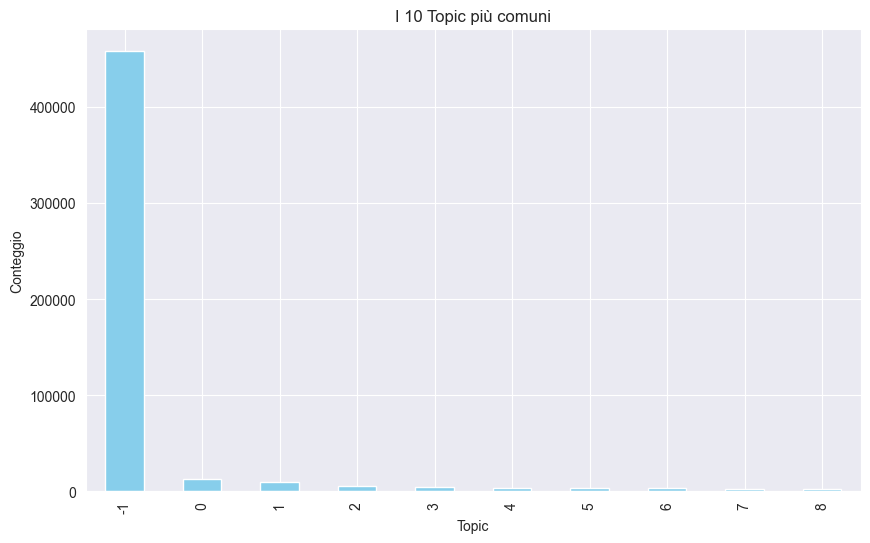

In [34]:
# Estrapola la colonna 'topics' e conta le occorrenze
topic_counts = lemmatized_text.explode('topics')['topics'].value_counts()

# Prendi i primi 10 topic più comuni
top_10_topics = topic_counts.head(10)

# Visualizza un grafico a barre
plt.figure(figsize=(10, 6))
top_10_topics.plot(kind='bar', color='skyblue')
plt.title('I 10 Topic più comuni')
plt.xlabel('Topic')
plt.ylabel('Conteggio')
plt.show()


#### 3.4.3. Word Cloud

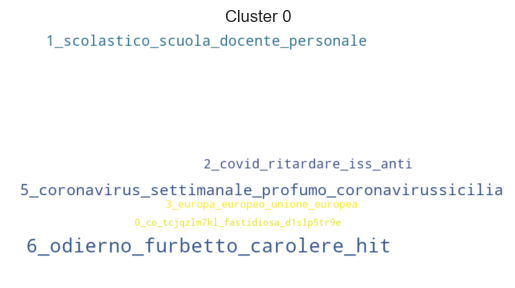

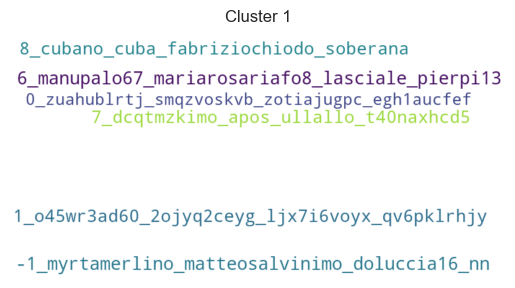

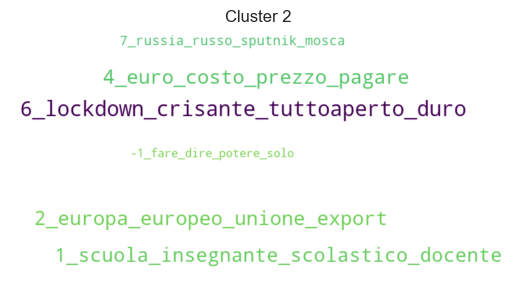

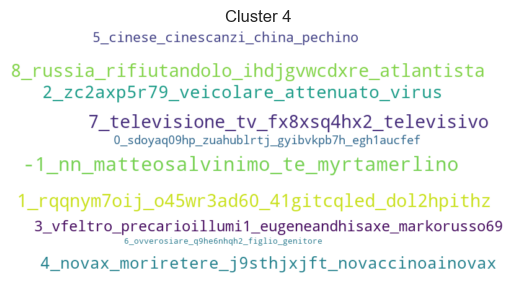

In [43]:
# Funzione per creare word clouds basate su keywords e probabilities
def create_word_cloud(keywords, probabilities):
    # Crea un dizionario di parole basato su keywords e probabilities
    word_freq = dict(zip(keywords, probabilities))
    
    # Crea una word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    return wordcloud

# Esegui la funzione per ogni cluster e visualizza le word clouds
unique_clusters = lemmatized_text['kmeans_cluster'].unique()

for cluster in unique_clusters:
    cluster_data = lemmatized_text[lemmatized_text['kmeans_cluster'] == cluster]
    
    # Prendi le prime 5/10 keywords e le relative probabilities
    # Nota: questo presuppone che i dati siano già ordinati in base alla probabilità
    keywords = cluster_data['model_info_name'].iloc[0][:10] 
    probabilities = cluster_data['probabilities'].iloc[0][:10]
    
    wordcloud = create_word_cloud(keywords, probabilities)
    
    # Visualizza la word cloud
    # plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster}')
    plt.show()
    
    # # Stampa le parole per il cluster corrente
    # print(f'Parole per il Cluster {cluster}:')
    # for word in keywords:
    #     print(word)
    # print("\n")  # Aggiunge una riga vuota tra le liste di parole


### 3.5. Estrazione delle parole chiave per ogni cluster

In [6]:
lemmatized_text = pd.read_pickle("../data/lemmatized_text.pkl")
lemmatized_text

,kmeans_cluster,processed_texts
0,0,[capo pfize albert bourla dichiarare vaccino s...
1,1,[tremonte tutto Europa usare palestre edificio...
2,2,[@maxdantone dire british Medical journal rece...
3,4,[politico avvertire imporre vaccino obbligator...


1. ```python
   common_words_per_cluster = {cluster: Counter(words).most_common() for cluster, words in cluster_tweets['words'].items()}
    ```
   Questa riga crea un dizionario dove ogni chiave è un identificatore di cluster e il valore è una lista di tuple. Ogni tupla contiene una parola e la sua frequenza nel cluster. Counter(words).most_common() restituisce una lista delle parole più comuni insieme alla loro frequenza.
2. ```python
   all_common_words = set(word for words in common_words_per_cluster.values() for word, count in words)
    ```
   all_common_words è un insieme di tutte le parole che sono comuni in qualsiasi cluster. Non stiamo cercando di rimuovere queste parole, stiamo solo creando un elenco di tutte le parole che sono comuni in qualsiasi cluster.
   La riga all_common_words = set(word for words in common_words_per_cluster.values() for word, count in words) sta creando questo insieme.
   Tuttavia, nel punto 3, si utilizza all_common_words per trovare le parole uniche in ogni cluster. In particolare, all_common_words - set(word for word, _ in words) sta creando un insieme di parole che sono comuni in tutti i cluster tranne quello corrente. Quindi, se una parola è nel cluster corrente ma non in questo insieme, allora quella parola è unica per il cluster corrente.
   In questo modo, otteniamo le parole che sono più comuni in un determinato cluster, ma non sono comuni negli altri cluster.
3. ```python
   unique_common_words_per_cluster = {cluster: set(word for word, count in words if word not in all_common_words - set(word for word, _ in words)) for cluster, words in common_words_per_cluster.items()}
    ```
   Questa riga crea un dizionario dove ogni chiave è un identificatore di cluster e il valore è un set di parole che sono più comuni solo in quel cluster specifico. Per ogni cluster, prende l'insieme di tutte le parole comuni (all_common_words) e ne rimuove le parole comuni di quel cluster, quindi verifica quali parole del cluster non fanno parte di questo insieme.
4. ```python
   unique_most_common_words_per_cluster = {cluster: [(word, count) for word, count in words if word in unique_common_words] for cluster, words in common_words_per_cluster.items()}
    ```
   Questa riga crea un dizionario dove ogni chiave è un identificatore di cluster e il valore è una lista di tuple. Ogni tupla contiene una parola e la sua frequenza nel cluster, ma solo per le parole che sono uniche per quel cluster (come identificato nella riga precedente).
5. ```python
   cluster_tweets['most_common_unique_words'] = pd.Series(unique_most_common_words_per_cluster)
    ```
   Infine, questa riga aggiunge i risultati al DataFrame esistente come una nuova colonna. Ogni cella in questa colonna sarà una lista di tuple, dove ogni tupla contiene una parola unica per quel cluster e la sua frequenza.



In [7]:
cluster_common_words = lemmatized_text.copy()

# cluster_common_words.loc[cluster_common_words['kmeans_cluster'] == 0, 'processed_texts'] = cluster_common_words.loc[cluster_common_words['kmeans_cluster'] == 0, 'processed_texts'].apply(lambda x: x[:500])
# cluster_common_words.loc[cluster_common_words['kmeans_cluster'] == 3, 'processed_texts'] = cluster_common_words.loc[cluster_common_words['kmeans_cluster'] == 3, 'processed_texts'].apply(lambda x: x[:500])

In [37]:
stop_words = set(stopwords.words('italian'))

def process_tweets(all_tweets):
    # Unisci tutti i tweet in un unico testo
    text = ' '.join(all_tweets)
    # Tokenizza il testo in parole
    words = nltk.word_tokenize(text)
    # Rimuovi le stop words e converti tutto in minuscolo
    words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
    # # Calcola la frequenza di ciascuna parola
    # freq = Counter(words)
    # Restituisci le 10 parole più comuni
    return words

# Applica la funzione a ciascun cluster
cluster_common_words['words'] = cluster_common_words['processed_texts'].apply(process_tweets)

# Prima creiamo un dizionario con le parole più comuni per ciascun cluster
common_words_per_cluster = {cluster: Counter(words) for cluster, words in cluster_common_words['words'].items()}

# Poi, creiamo un set con tutte le parole più comuni nei vari cluster
all_common_words = set(word for words in common_words_per_cluster.values() for word, count in words.keys())

# Trova le parole uniche per ciascun cluster
unique_words_per_cluster = {cluster: [word for word in words.keys() if word not in all_common_words - set(words.keys())] for cluster, words in common_words_per_cluster.items()}

# # Trova le parole più comuni uniche per ciascun cluster
# unique_most_common_words_per_cluster = {cluster: [(word, words[word]) for word in unique_words_per_cluster[cluster]] for cluster, words in common_words_per_cluster.items()}
# Trova le parole più comuni uniche per ciascun cluster
unique_most_common_words_per_cluster = {cluster: sorted([(word, words[word]) for word in unique_words_per_cluster[cluster]], key=lambda x: x[1], reverse=True)[:10] for cluster, words in common_words_per_cluster.items()}

# Aggiungiamo le parole più comuni uniche per ciascun cluster al DataFrame
cluster_tweets['most_common_unique_words'] = pd.Series(unique_most_common_words_per_cluster)

print(cluster_tweets['most_common_unique_words'])


,kmeans_cluster,processed_texts,words
0,0,[politico avvertire imporre vaccino obbligator...,"[politico, avvertire, imporre, vaccino, obblig..."
1,1,[radioanchio @giorgiozanchini 22dicembre @radi...,"[radioanchio, giorgiozanchini, varianteinglese..."
2,2,[segreto vaccino buongiorno primapagino repubb...,"[segreto, vaccino, buongiorno, primapagino, re..."
3,3,[ora prevedere vaccinare bambino \n\n ora \n\n...,"[ora, prevedere, vaccinare, bambino, ora, ora,..."
4,4,[vaccino tracciamento digitale //t.co vguar139...,"[vaccino, tracciamento, digitale, vaccinationd..."
5,5,[cosa immunodepresso raga cioè tipo costanteme...,"[cosa, immunodepresso, raga, cioè, tipo, costa..."
6,6,[@rosario04719767 antivaccinaro viscerale prem...,"[antivaccinaro, viscerale, premetto, massimo, ..."
7,7,[variare covid(a parte fatto sembrare pò tardi...,"[variare, covid, parte, fatto, sembrare, pò, t..."


In [4]:
from tqdm import tqdm
from collections import Counter

stop_words = set(stopwords.words('italian'))

# Creiamo un dizionario vuoto per memorizzare le parole più comuni per ciascun cluster
common_words_per_cluster = {}

# Creiamo un set vuoto per memorizzare tutte le parole più comuni
all_common_words = set()

# Creiamo un dizionario vuoto per memorizzare le parole uniche per ciascun cluster
unique_words_per_cluster = {}

# Creiamo un dizionario vuoto per memorizzare le parole più comuni uniche per ciascun cluster
unique_most_common_words_per_cluster = {}

# Iteriamo su ciascun cluster utilizzando tqdm per visualizzare il progresso
for cluster in tqdm(cluster_common_words.index, total=len(cluster_common_words)):

    # Estraiamo tutti i tweet per il cluster corrente
    all_tweets = cluster_common_words.loc[cluster, 'processed_texts']

    # Uniamo tutti i tweet in un unico testo e tokenizziamo il testo in parole
    words = nltk.word_tokenize(' '.join(all_tweets))

    # Rimuoviamo le stop words e convertiamo tutto in minuscolo
    words = [word.lower() for word in words if word.isalpha() and word not in stop_words]

    # Calcoliamo la frequenza di ciascuna parola e la memorizziamo nel dizionario
    common_words_per_cluster[cluster] = Counter(words)

    # Aggiungiamo le parole più comuni al set di tutte le parole comuni
    all_common_words.update([word for word, count in common_words_per_cluster[cluster].items()])

# Calcoliamo le parole uniche per ciascun cluster
for cluster in tqdm(common_words_per_cluster.keys(), total=len(common_words_per_cluster)):
    unique_words_per_cluster[cluster] = [word for word in common_words_per_cluster[cluster].keys() if word not in all_common_words - set(common_words_per_cluster[cluster].keys())]

# Calcoliamo le parole più comuni uniche per ciascun cluster
for cluster in tqdm(unique_words_per_cluster.keys(), total=len(unique_words_per_cluster)):
    unique_most_common_words_per_cluster[cluster] = sorted([(word, common_words_per_cluster[cluster][word]) for word in unique_words_per_cluster[cluster]], key=lambda x: x[1], reverse=True)[:10]

# Aggiungiamo le parole più comuni uniche per ciascun cluster al DataFrame
cluster_common_words['most_common_unique_words'] = pd.Series(unique_most_common_words_per_cluster)

print(cluster_common_words['most_common_unique_words'])


  0%|          | 0/8 [2:22:11<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import nltk
from collections import Counter
from multiprocessing import Pool, cpu_count

stop_words = set(stopwords.words('italian'))

def process_tweets(all_tweets):
    text = ' '.join(all_tweets)
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
    return words

def compute_unique_words(cluster_data):
    cluster, data = cluster_data
    common_words = Counter(data['words'])
    all_common_words = set(word for words in common_words_per_cluster.values() for word, count in words.keys())
    unique_words = [word for word in common_words.keys() if word not in all_common_words - set(common_words.keys())]
    unique_most_common = sorted([(word, common_words[word]) for word in unique_words], key=lambda x: x[1], reverse=True)[:10]
    return cluster, unique_most_common

# Applica la funzione a ciascun cluster
cluster_common_words['words'] = cluster_common_words['processed_texts'].apply(process_tweets)

# Prima creiamo un dizionario con le parole più comuni per ciascun cluster
common_words_per_cluster = {cluster: Counter(words) for cluster, words in cluster_common_words['words'].items()}

# Utilizziamo multiprocessing per calcolare le parole uniche
# Creiamo un pool di processi (utilizziamo 6 come richiesto)
pool = Pool(6)

# Distribuiamo il carico di lavoro tra i processi
results = pool.map(compute_unique_words, common_words_per_cluster.items())

# Chiudiamo il pool di processi
pool.close()
pool.join()

# Convertiamo i risultati in un dizionario
unique_most_common_words_per_cluster = dict(results)

# Aggiungiamo le parole più comuni uniche per ciascun cluster al DataFrame
cluster_tweets['most_common_unique_words'] = pd.Series(unique_most_common_words_per_cluster)

print(cluster_tweets['most_common_unique_words'])


In [ ]:
# Stampa le 10 parole più comuni uniche per ciascun cluster
for k, words in unique_common_words_per_cluster.items():
    print(f'Cluster {k}: {words[:10]}')

In [ ]:
for index, row in cluster_tweets.iterrows():
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(dict(row['most_common_words']))

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f'Cluster {index} - Most Common Words')
    plt.show()
